<a href="https://colab.research.google.com/github/shreevigneshs/UCSC-243/blob/main/assignments/1_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 6.4 MB/s 


In [14]:
# !pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandarallel: filename=pandarallel-1.6.3-py3-none-any.whl size=16463 sha256=22f54b87e5a9dda2f6ddd379b55a2955b508dde8c669c19ec96080beabb5fe18
  Stored in directory: /root/.cache/pip/wheels/3c/a4/19/02a1f08d032a017d5d7e22da595aa652ba0a2f2e22de73981b
Successfully built pandarallel


In [118]:
from typing import List
import re
import string
import math
import os

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

from tqdm import tqdm
import spacy

from sklearn.model_selection import train_test_split
import skmultilearn
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
import pickle as pkl
from argparse import Namespace

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/NLP243/assignments/1/hw1_train-1.csv")
# df["split"] = "train"
# df.columns = ["id", "text", "labels", "split"]
# df.labels = df.labels.replace(np.nan, "none", regex=True)

In [ ]:
# np.random.seed(20221002)
# train_proportion = 0.80
# val_proportion = 0.20

In [ ]:
# item_list = list(row.to_dict() for _, row in df.iterrows())
# np.random.shuffle(item_list)

In [ ]:
# # Create split data
# final_list = []

# n_total = len(item_list)
# n_train = int(train_proportion * n_total)
# n_val = int(val_proportion * n_total)

# # Give data point a split attribute
# for item in item_list[:n_train]:
#   item['split'] = 'train'
    
# for item in item_list[n_train:n_train+n_val+1]:
#   item['split'] = 'val'

# # Add to final list
# final_list.extend(item_list)

# final_df = pd.DataFrame(final_list)

In [ ]:
# print(final_df)

In [ ]:
# nlp = spacy.load("en_core_web_sm")

In [4]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r"([.,!?])", r" \1 ", text)
  text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
  return text

In [ ]:
# final_df.text = final_df.text.apply(preprocess_text)

In [ ]:
# print(final_df.text)

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv")
# tfidf_vectroizer = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)
# X = tfidf_vectroizer.fit_transform(list(df.text))
# a = dict(zip(tfidf_vectroizer.get_feature_names(), tfidf_vectroizer.idf_))
# for _x , _y in dict(sorted(a.items(), key=lambda item: item[1], reverse = True)).items():
#   print(_x, " : ", _y)
# print(len(a))


In [ ]:
# final_df.to_csv("/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv")

In [ ]:
# nlp = spacy.load("en_core_web_sm")
# spacy_lemmatized_texts = [" ".join([_token.lemma_ for _token in _doc]) for _doc in nlp.pipe(processed_df.text)]

In [ ]:
# print(spacy_lemmatized_texts[:3])

In [ ]:
# spacy_lemmatized_df = processed_df
# spacy_lemmatized_df.text = spacy_lemmatized_texts
# spacy_lemmatized_df.tail()

In [ ]:
# spacy_lemmatized_df.to_csv("/content/drive/MyDrive/NLP243/assignments/1/spacy_lemmatized_hw1_train-1.csv")

In [ ]:
processed_df = pd.read_csv("/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv")
processed_df.tail()

In [ ]:
processed_and_split_df = processed_df
processed_and_split_df.labels = processed_and_split_df.labels.str.split(" ")
processed_and_split_df.tail()

In [ ]:
# most common wordds per label

processed_and_split_df_small = processed_and_split_df[2300:]
processed_and_split_df_small_exploded = processed_and_split_df_small.explode("labels")
print(processed_and_split_df_small_exploded)

In [ ]:
any(processed_and_split_df.labels.isna().to_list())

In [ ]:
processed_and_split_df_explode = processed_and_split_df.explode("labels")
processed_and_split_df_explode.tail()

In [ ]:
pandarallel.initialize(progress_bar=True)
processed_and_split_df_explode["words"] = processed_and_split_df_explode["text"].parallel_map(lambda x: x.split())
processed_and_split_words_df_explode = (
    processed_and_split_df_explode
    .drop(columns=['text'])
    .explode('words')
)
processed_and_split_words_df_explode.tail()

In [ ]:
processed_and_split_words_df_explode[processed_and_split_words_df_explode['words'].str.isalnum().fillna(False)]

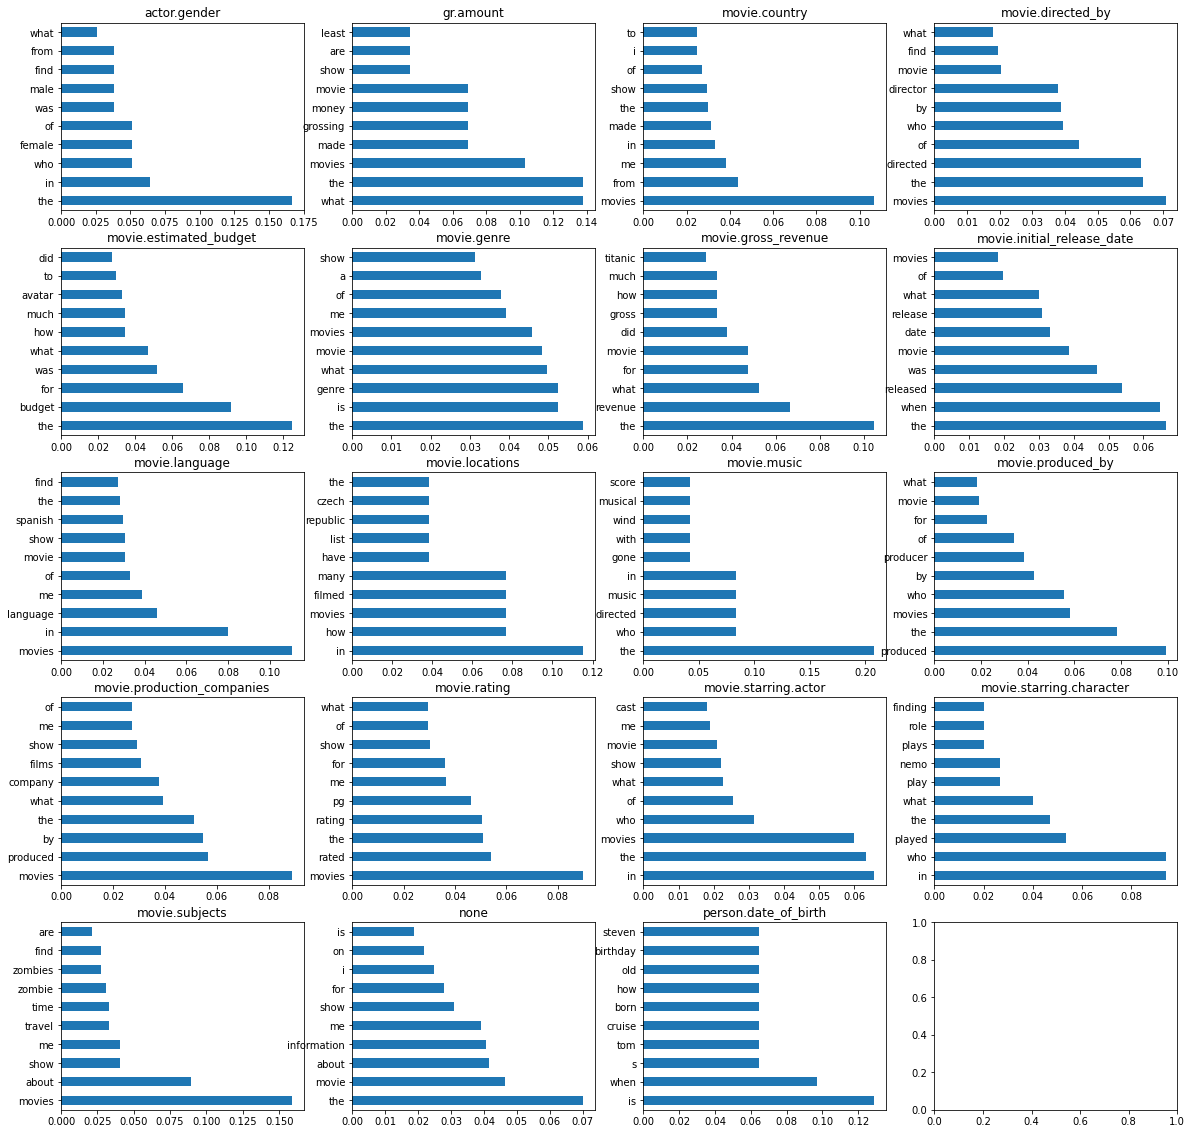

In [32]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20))

groups = processed_and_split_words_df_explode.groupby('labels')['words']
for ax, (name, _df) in zip(axes.flatten(), groups):
    ax.set_title(name)
    top_ten_words = _df.value_counts()[:10] / len(_df)
    top_ten_words.plot(kind='barh', ax=ax)

In [73]:
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<unk>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [72]:
class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, text_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.text_vocab = text_vocab
        # self.label_vocab = label_vocab

    def vectorize(self, text):
        """Create a collapsed one-hit vector for the review
        
        Args:
            review (str): the review
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.text_vocab), dtype=np.float32)
        
        for token in text.split():
            if token not in string.punctuation:
                one_hot[self.text_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, df, cutoff=1100):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        text_vocab = Vocabulary(add_unk=True)
        
        # label_vocab = Vocabulary(add_unk=False)
        
        # # Add ratings
        # for rating in sorted(set(df.labels)):
        #     rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for text in df.text:
            for word in text.split():
                if word not in string.punctuation:
                    word_counts[word] += 1
        
        # print(word_counts.most_common(100))

        # print(word_counts.most_common())
        print(len(word_counts.most_common()))

        for word, count in dict(word_counts.most_common(cutoff)).items():
            text_vocab.add_token(word)
        
        # for word, count in word_counts.items():
        #     if count > cutoff:
        #         text_vocab.add_token(word)

        # return cls(review_vocab, rating_vocab)
        
        return cls(text_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        text_vocab = Vocabulary.from_serializable(contents['text_vocab'])

        return cls(text_vocab=text_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        # return {'review_vocab': self.review_vocab.to_serializable(),
        #         'rating_vocab': self.rating_vocab.to_serializable()}

        return {'text_vocab': self.text_vocab.to_serializable()}

In [71]:
# Label Indexer
# For converting labels into indices 0 - L1, 1 - L2

class LabelIndexer(object):
    def __init__(self, labels, label2idx=None, idx2label=None):

        # self.labels = list(set([_split_label for label in movie_df.labels.unique().flatten() for _split_label in label.split()]))
        
        self.labels = labels
        self.n_labels = len(self.labels)
        self.label2idx = {label: i for i, label in enumerate(self.labels)} if label2idx is None else label2idx
        self.idx2label = {i:label for label, i in self.label2idx.items()} if idx2label is None else idx2label

    def encode(self, y):
        one_hot_encoded = np.zeros(self.n_labels, dtype=int)
        normalized_label = list(set([_split_label for _split_label in y.split()]))
        for _label in normalized_label:
          one_hot_encoded[self.label2idx[_label]] = 1.
        return one_hot_encoded

    def encode_batch(self, ys):
        return torch.LongTensor([self.encode(y) for y in ys])
    
    @classmethod
    def from_dataframe(cls, df):
        labels = list(set([_split_label for label in df.labels.unique().flatten() for _split_label in label.split()]))
        return cls(labels)
    
    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        labels = LabelIndexer.from_serializable(contents['labels'])
        label2idx = LabelIndexer.from_serializable(contents['label2idx'])
        idx2label = LabelIndexer.from_serializable(contents['idx2label'])
        
        return cls(labels=labels, label2idx=label2idx, idx2label=idx2label)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        # return {'review_vocab': self.review_vocab.to_serializable(),
        #         'rating_vocab': self.rating_vocab.to_serializable()}

        return {
            'labels': self.labels.to_serializable(),
            'label2idx': self.label2idx.to_serializable(),
            'idx2label': self.idx2label.to_serializable()
        }
    
    def __str__(self):
        return "<LabelIndexer(size=%d)>" % len(self)

    def __len__(self):
        return self.n_labels


In [109]:
class MovieDataset(Dataset):
    def __init__(self, movie_df, vectorizer, label_indexer, tfidf=False):
        """
        Args:
            movie_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.movie_df = movie_df
        self._vectorizer = vectorizer
        self._label_indexer = label_indexer

        # self.train_df = self.movie_df[self.movie_df.split=='train']
        self.train_df = self.movie_df
        self.train_size = len(self.train_df)

        self.val_df = self.movie_df[self.movie_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')

        self.tfidf = tfidf
        if self.tfidf:
            self._vectorizer.fit(list(self.train_df.text))

    @classmethod
    def load_dataset_and_make_vectorizer_and_label_indexer(cls, movie_csv, tfidf=False):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        movie_df = pd.read_csv(movie_csv)

        if tfidf:
          tfidf_vectroizer = TfidfVectorizer(ngram_range=(1,2), norm=None, smooth_idf=False, use_idf=False)
          return cls(movie_df, tfidf_vectroizer, LabelIndexer.from_dataframe(movie_df), tfidf=True)
        else:
          return cls(movie_df, Vectorizer.from_dataframe(movie_df), LabelIndexer.from_dataframe(movie_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_label_indexer(self):
        """ returns label indexer """
        return self._label_indexer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train" or "val"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        if self.tfidf:
          text_vector = torch.FloatTensor(self._vectorizer.transform([row.text]).todense()).squeeze(0)

        else:
          text_vector = \
              self._vectorizer.vectorize(row.text)

        label_index = \
            self._label_indexer.encode(row.labels)

        return {'x_data': text_vector,
                'y_target': label_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

In [74]:
dataset = MovieDataset.load_dataset_and_make_vectorizer_and_label_indexer(movie_csv="/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv")
vectorizer = dataset.get_vectorizer()
label_indexer = dataset.get_label_indexer()

1132


In [ ]:
x = pkl.dumps(label_indexer)
print(x)

In [ ]:
y = pkl.loads(x)
print(y)

In [ ]:
label_indexer.label2idx

In [ ]:
y.label2idx

In [81]:
# data loader

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [82]:
batched_data = generate_batches(dataset=dataset, batch_size=2)

In [167]:
# Zipping the dataloader with range(N) lets us only print the first N batches
for _, batch in zip(range(5), batched_data):
    print(batch["x_data"].shape, batch["y_target"].shape)
    b = batch["x_data"][0] > 0
    print(any(b.tolist()))
    # Do something here; maybe print the batch to see if it looks right to you?
    # print(batch.shape)

torch.Size([2, 1101]) torch.Size([2, 19])
True
torch.Size([2, 1101]) torch.Size([2, 19])
True
torch.Size([2, 1101]) torch.Size([2, 19])
True
torch.Size([2, 1101]) torch.Size([2, 19])
True
torch.Size([2, 1101]) torch.Size([2, 19])
True


In [174]:
class MLPMultiLabelClassifier(nn.Module):
    """ a simple perceptron-based classifier """
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1, use_dropout=True, use_batch_norm=True):
        super(MLPMultiLabelClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = nn.Linear(in_features=input_size, 
                             out_features=hidden_size, bias=True)
        self.batch_norm1 = nn.BatchNorm1d(num_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
        self.dropout = nn.Dropout(dropout_p)
        self.apply(self._init_weights)
    
    def _init_weights(self, module, input_size=0, output_size=0):
        # for every Linear layer in a model..
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight.data, nonlinearity='relu')
            
            #if need to do it manual
            # std = math.sqrt(2.0/input_size)
            # weights = torch.randn(input_size, output_size)
            # scaled_weights = torch.mul(weights, std)
            # module.weight.data = torch.nn.Parameter(scaled_weights)
            
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x_in):
        y1_out = F.relu(self.batch_norm1(self.fc1(x_in).squeeze()))
        y2_out = self.fc2(self.dropout(y1_out)).squeeze()
        y_out = y2_out
        return y_out

In [115]:
# model 6 is after lemmatizing, removing verbs and removing stop words which turns out is not good
# model 7 is after lemmatizing and removing verbs, turns out is again not that great
# model 8 is after just lemmatizing
# model 9 is after just lemmatizing, bathc size 64 and hidden layers 128

# 20221007
# model 1 - base model batch size 64, hidden layers 1, hiden size 100, learning rate 0.001, epochs 30
# model 1_full - base model batch size 64, hidden layers 1, hiden size 100, learning rate 0.001, epochs 100
# model 2 - base model batch size 64, hidden layers 1, hiden size 100, learning rate 0.001, epochs 100
# model 2_full - base model batch size 64, hidden layers 1, hiden size 100, learning rate 0.001, epochs 100
# model 3 - base model batch size 64, hidden layers 1, hiden size 100, learning rate 0.001, epochs 500
# model 4_full - base model batch size 16, hidden layers 1, hiden size 100, learning rate 0.001, epochs 100

In [176]:
model_number = '4_full'
args = Namespace(
    # Data and path information
    movie_csv='/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv',
    save_dir='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/',
    model_number=model_number,
    dataset_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/dataset.pkl'.format(model_number),
    vectroizer_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/vectroizer.pkl'.format(model_number),
    label_indexer_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/label_indexer.pkl'.format(model_number),
    model_state_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/model.pth'.format(model_number),
    train_state_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/train_state.pkl'.format(model_number),
    submission_path = '/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/submission.csv'.format(model_number),
    # Training hyperparameters
    hidden_size=100,
    batch_size=16,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100
    # Runtime options omitted for space
)

if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

1132
Train classification report after epoch: 0
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       0.08      0.10      0.09       129
       movie.gross_revenue       0.00      0.00      0.00        34
              movie.rating       0.36      0.30      0.32       210
movie.initial_release_date       0.32      0.46      0.37       189
            movie.language       0.44      0.34      0.38       220
               movie.music       0.01      0.33      0.02         3
movie.production_companies       0.03      0.03      0.03        93
      movie.starring.actor       0.72      0.26      0.38       355
            movie.subjects       0.08      0.14      0.10        93
                      none       0.55      0.32      0.41       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       0.12      0.41      0.19        79

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 1
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.40      0.57       128
       movie.gross_revenue       1.00      0.06      0.11        34
              movie.rating       1.00      0.75      0.86       208
movie.initial_release_date       0.99      0.67      0.80       189
            movie.language       0.97      0.71      0.82       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.92      0.26      0.41        92
      movie.starring.actor       0.95      0.66      0.78       354
            movie.subjects       1.00      0.44      0.61        93
                      none       0.92      0.66      0.77       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       0.98      0.78      0.87        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 2
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.65      0.79       128
       movie.gross_revenue       1.00      0.47      0.64        34
              movie.rating       1.00      0.94      0.97       211
movie.initial_release_date       0.99      0.87      0.93       188
            movie.language       0.99      0.91      0.95       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.93      0.62      0.75        92
      movie.starring.actor       0.97      0.87      0.92       354
            movie.subjects       1.00      0.85      0.92        93
                      none       0.94      0.80      0.86       319
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.92      0.96        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 3
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.86      0.92       129
       movie.gross_revenue       1.00      0.68      0.81        34
              movie.rating       1.00      0.98      0.99       209
movie.initial_release_date       0.99      0.90      0.95       186
            movie.language       0.99      0.93      0.96       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.96      0.84      0.90        93
      movie.starring.actor       0.98      0.92      0.95       355
            movie.subjects       1.00      0.98      0.99        94
                      none       0.97      0.88      0.92       317
              actor.gender       1.00      0.44      0.62         9
    movie.estimated_budget       1.00      0.99      0.99        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 4
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.92      0.96       128
       movie.gross_revenue       1.00      0.88      0.94        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.94      0.97       189
            movie.language       1.00      0.97      0.98       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.97      0.97        93
      movie.starring.actor       0.98      0.97      0.97       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.95      0.90      0.92       318
              actor.gender       1.00      0.44      0.62         9
    movie.estimated_budget       0.99      0.97      0.98        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 5
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.98      0.99       129
       movie.gross_revenue       1.00      0.94      0.97        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.97      0.98       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.33      0.50         3
movie.production_companies       0.97      1.00      0.98        93
      movie.starring.actor       0.98      0.97      0.98       353
            movie.subjects       1.00      0.99      0.99        93
                      none       0.98      0.92      0.95       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 6
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.40      0.57         5
               movie.genre       1.00      0.98      0.99       128
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      0.99      1.00       208
movie.initial_release_date       0.99      0.99      0.99       187
            movie.language       1.00      0.99      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.97      0.98      0.97        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      0.99      0.99        94
                      none       0.98      0.92      0.95       318
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      1.00      1.00        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 7
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.60      0.75         5
               movie.genre       1.00      0.98      0.99       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      0.99       209
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      0.99      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.97      1.00      0.98        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.95      0.96       318
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      0.99      0.99        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 8
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.98      1.00      0.99        91
      movie.starring.actor       0.99      0.98      0.98       353
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.95      0.97       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 9
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.97      0.98       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       0.99      0.98      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.96      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       0.99      1.00      0.99        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 10
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       186
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         8
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 11
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.95      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 12
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.98      0.99       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.98      0.96      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 13
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 14
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.98      0.98      0.98        92
      movie.starring.actor       0.99      0.98      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.96      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 15
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.98      0.98      0.98       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.98      0.96      0.97        93
      movie.starring.actor       0.99      0.98      0.98       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.96      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 16
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      0.99       210
movie.initial_release_date       1.00      0.98      0.99       187
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      0.99      0.99        94
                      none       0.98      0.97      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        77
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 17
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      0.99       188
            movie.language       1.00      1.00      1.00       217
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       0.99      0.98      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 18
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.97      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 19
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      1.00       211
movie.initial_release_date       0.99      0.98      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        92
      movie.starring.actor       0.99      0.98      0.99       355
            movie.subjects       1.00      1.00      1.00        92
                      none       0.97      0.97      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 20
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.98      0.98       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       315
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 21
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      0.99      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      0.97      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 22
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.97      0.98       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.97      0.98        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.97      0.97      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       0.99      1.00      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 23
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.97      0.98        93
      movie.starring.actor       1.00      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 24
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      0.98      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      1.00      0.99        92
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.97      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 25
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        91
                      none       1.00      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         8
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 26
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 27
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.98      0.99       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       1.00      0.99      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 28
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 29
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       187
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.96      1.00      0.98        93
      movie.starring.actor       0.99      1.00      0.99       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 30
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.98      0.99       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      0.98      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 31
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      0.99      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      0.99      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      1.00      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 32
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.99      0.99        92
      movie.starring.actor       1.00      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.96      0.97       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 33
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        92
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.98      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 34
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      0.98      0.99       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.95      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 35
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       187
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.99      0.99        92
      movie.starring.actor       0.99      0.98      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 36
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       187
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.98      0.99        92
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.97      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 37
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      0.99      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.98      0.99       351
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 38
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.98      0.99       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 39
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       0.99      0.98      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.97      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 40
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 41
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.98      1.00      0.99       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      0.98      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.96      0.97       319
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 42
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.98      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.98      0.98        92
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.98      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       0.99      0.99      0.99        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 42
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      1.00      1.00        31
       movie.gross_revenue       1.00      1.00      1.00         7
              movie.rating       1.00      1.00      1.00        41
movie.initial_release_date       1.00      1.00      1.00        41
            movie.language       1.00      1.00      1.00        37
               movie.music       0.00      0.00      0.00         0
movie.production_companies       1.00      1.00      1.00        15
      movie.starring.actor       1.00      1.00      1.00        76
            movie.subjects       1.00      1.00      1.00         9
                      none       1.00      0.98      0.99        64
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        16
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Train classification report after epoch: 43
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.98      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.98      0.98        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 43
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      1.00      1.00        30
       movie.gross_revenue       1.00      1.00      1.00         6
              movie.rating       1.00      1.00      1.00        41
movie.initial_release_date       0.98      1.00      0.99        40
            movie.language       1.00      1.00      1.00        36
               movie.music       0.00      0.00      0.00         0
movie.production_companies       1.00      1.00      1.00        15
      movie.starring.actor       1.00      1.00      1.00        79
            movie.subjects       1.00      1.00      1.00         9
                      none       1.00      1.00      1.00        64
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        16
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 44
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.96      0.97       318
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 45
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      0.99      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.98      0.98        93
      movie.starring.actor       1.00      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.98      0.98       315
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       0.99      0.99      0.99        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 46
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.98      0.99       128
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 47
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.98      0.99       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       1.00      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        92
                      none       0.97      0.97      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 48
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.98      0.98        92
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 49
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 50
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       350
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.95      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 51
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      0.97      0.98        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 52
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      1.00      0.99        92
      movie.starring.actor       0.99      0.99      0.99       352
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       319
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 53
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      0.99      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 54
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      0.99      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 55
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      1.00      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       0.98      0.97      0.98       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       0.99      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 55
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      1.00      1.00        30
       movie.gross_revenue       1.00      1.00      1.00         7
              movie.rating       1.00      1.00      1.00        40
movie.initial_release_date       1.00      1.00      1.00        40
            movie.language       1.00      1.00      1.00        36
               movie.music       0.00      0.00      0.00         0
movie.production_companies       1.00      1.00      1.00        15
      movie.starring.actor       0.99      1.00      0.99        74
            movie.subjects       1.00      1.00      1.00         9
                      none       1.00      0.99      0.99        68
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        16
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Train classification report after epoch: 56
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.98      0.99       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.98      0.99        93
      movie.starring.actor       0.98      0.97      0.98       355
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 57
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       1.00      0.98      0.99       353
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.97      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 58
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.98      0.99       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.97      0.98        92
      movie.starring.actor       1.00      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.97      0.97      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 59
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.98      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 60
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 61
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.98      0.98        93
      movie.starring.actor       0.99      0.99      0.99       352
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 62
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.98      0.99        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 63
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       0.99      0.97      0.98       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.98      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 64
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      0.99       210
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 65
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         2
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       0.99      0.98      0.98       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 66
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.98        32
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.97      0.98        93
      movie.starring.actor       1.00      0.99      1.00       354
            movie.subjects       1.00      0.98      0.99        93
                      none       0.98      0.96      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 67
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.97      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.97      0.97        93
      movie.starring.actor       1.00      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       315
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 68
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.98      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        92
      movie.starring.actor       0.99      0.99      0.99       352
            movie.subjects       1.00      0.98      0.99        93
                      none       0.99      0.97      0.98       319
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      0.97      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 69
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       315
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 70
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      0.99      0.99       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       189
            movie.language       1.00      0.99      0.99       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      0.99      0.99        93
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 71
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.97      0.98        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      1.00      1.00        31
       movie.gross_revenue       1.00      1.00      1.00         7
              movie.rating       1.00      1.00      1.00        41
movie.initial_release_date       1.00      1.00      1.00        41
            movie.language       1.00      1.00      1.00        37
               movie.music       0.00      0.00      0.00         0
movie.production_companies       1.00      1.00      1.00        14
      movie.starring.actor       1.00      1.00      1.00        77
            movie.subjects       1.00      1.00      1.00         9
                      none       1.00      1.00      1.00        66
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        15
      person.date_of_birth       1.00      1.00

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 72
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      0.99      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.98      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 73
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      0.99      0.99        92
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 74
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.97      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 75
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.98      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      0.99      0.99        93
                      none       0.97      0.97      0.97       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 76
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.97      0.96      0.96        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      0.99      0.99        93
                      none       0.98      0.97      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 77
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       187
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.97      0.98        92
      movie.starring.actor       0.99      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 78
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        92
                      none       0.98      0.97      0.97       319
              actor.gender       1.00      1.00      1.00         8
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 78
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      1.00      1.00        30
       movie.gross_revenue       1.00      1.00      1.00         7
              movie.rating       1.00      1.00      1.00        41
movie.initial_release_date       1.00      1.00      1.00        41
            movie.language       1.00      1.00      1.00        38
               movie.music       0.00      0.00      0.00         0
movie.production_companies       1.00      1.00      1.00        15
      movie.starring.actor       1.00      1.00      1.00        77
            movie.subjects       1.00      1.00      1.00         9
                      none       1.00      1.00      1.00        62
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        16
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 79
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch: 79
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      1.00      1.00        30
       movie.gross_revenue       1.00      1.00      1.00         7
              movie.rating       1.00      1.00      1.00        41
movie.initial_release_date       1.00      1.00      1.00        40
            movie.language       1.00      1.00      1.00        37
               movie.music       0.00      0.00      0.00         0
movie.production_companies       1.00      1.00      1.00        14
      movie.starring.actor       1.00      1.00      1.00        77
            movie.subjects       1.00      1.00      1.00         9
                      none       1.00      1.00      1.00        65
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        16
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 80
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.98      0.99        91
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.98       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       0.99      0.99      0.99        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 81
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        92
      movie.starring.actor       1.00      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 82
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.98      0.98      0.98       187
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      0.99      0.99       352
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 83
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      0.99      0.99        93
                      none       1.00      0.99      1.00       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 84
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       187
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        92
      movie.starring.actor       0.99      0.98      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.98      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 85
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       217
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 86
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.98      0.98       187
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.96      0.97        93
      movie.starring.actor       0.99      0.99      0.99       352
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 87
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      0.99       208
movie.initial_release_date       0.99      0.98      0.98       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 88
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      0.99      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.98      0.98        93
      movie.starring.actor       0.99      0.98      0.98       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 89
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      1.00       210
movie.initial_release_date       0.99      0.98      0.99       189
            movie.language       1.00      0.99      0.99       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.98      0.99       355
            movie.subjects       1.00      1.00      1.00        92
                      none       0.98      0.98      0.98       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 90
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        91
      movie.starring.actor       0.99      0.98      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 91
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       217
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.97      0.97       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 92
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      1.00       211
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      0.98      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 93
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      0.99      0.99        94
                      none       1.00      0.98      0.99       319
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 94
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       187
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.96      0.97       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 95
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      0.99      1.00       210
movie.initial_release_date       0.99      0.97      0.98       187
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 96
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      0.99      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       0.99      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      0.98      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 97
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       188
            movie.language       1.00      0.99      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.98      0.98      0.98       352
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         8
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 98
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      0.98      0.99       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 99
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.98      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        92
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

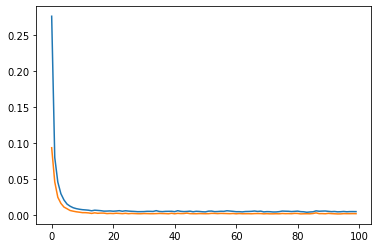

In [178]:
# training state
def make_train_state(args):
    return {'epoch_index': 0,
            'train_loss': [],
            'train_all_true_labels': [],
            'train_all_pred_labels': [],
            'train_classification_report': [],
            'val_loss': [],
            'val_all_true_labels': [],
            'val_all_pred_labels': [],
            'val_classification_report': [],
            'test_loss': [],
            'test_classification_report': []}
train_state = make_train_state(args)

# instantiate dataset

# dataset and vectorizer
# dataset = MovieDataset.load_dataset_and_make_vectorizer_and_label_indexer(args.movie_csv, tfidf=True)
dataset = MovieDataset.load_dataset_and_make_vectorizer_and_label_indexer(args.movie_csv)
vectorizer = dataset.get_vectorizer()
label_indexer = dataset.get_label_indexer()

if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
if not os.path.exists(os.path.join(args.save_dir, args.model_number)):
    os.mkdir(os.path.join(args.save_dir, args.model_number))
with open(args.dataset_file, "wb") as output_file:
    pkl.dump(dataset, output_file)
with open(args.vectroizer_file, "wb") as output_file:
    pkl.dump(vectorizer, output_file)
with open(args.label_indexer_file, "wb") as output_file:
    pkl.dump(label_indexer, output_file)

labels = [label_indexer.idx2label[_idx] for _idx in range(len(label_indexer))]

# model
classifier = MLPMultiLabelClassifier(input_size=len(vectorizer.text_vocab), hidden_size=args.hidden_size, output_size=len(label_indexer))
classifier = classifier.to(args.device)

# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=1e-4)

for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    # Iterate over training dataset

    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.0

    batch_wise_true_labels = []
    batch_wise_predictions = []

    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:

        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        
        # print("y_pred: {}".format(y_pred))

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].squeeze().float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # clip the grad norm
        nn.utils.clip_grad_norm_(classifier.parameters(), 3.0)

        # step 5. use optimizer to take gradient step
        optimizer.step()

        # -----------------------------------------
        # compute the metrics

        y_pred_normalized = F.sigmoid(y_pred)
        y_pred_labels = y_pred_normalized >= 0.5
        
        batch_wise_true_labels.append(batch_dict['y_target'].tolist())
        batch_wise_predictions.append(y_pred_labels.tolist())

    train_state['train_loss'].append(running_loss)
    
    all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    all_pred_labels = list(chain.from_iterable(batch_wise_predictions))
    train_state['train_all_true_labels'].append(all_true_labels)
    train_state['train_all_pred_labels'].append(all_pred_labels)

    # Now we can generate a classification report
    print("Train classification report after epoch: {}".format(train_state['epoch_index']))
    train_classification_report = classification_report(all_true_labels, all_pred_labels, target_names=labels)
    train_state['train_classification_report'].append(train_classification_report)
    print(train_classification_report)

    # Iterate over val dataset

    # setup: batch generator, set loss and acc to 0, set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.

    classifier.eval()

    batch_wise_true_labels = []
    batch_wise_predictions = []

    for batch_index, batch_dict in enumerate(batch_generator):

        # step 1. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # step 2. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].squeeze().float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 3. compute the metrics

        y_pred_normalized = F.sigmoid(y_pred)
        y_pred_labels = y_pred_normalized >= 0.5
        
        batch_wise_true_labels.append(batch_dict['y_target'].tolist())
        batch_wise_predictions.append(y_pred_labels.tolist())

    train_state['val_loss'].append(running_loss)
    
    all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    all_pred_labels = list(chain.from_iterable(batch_wise_predictions))
    train_state['val_all_true_labels'].append(all_true_labels)
    train_state['val_all_pred_labels'].append(all_pred_labels)

    # Now we can generate a classification report
    print("Val classification report after epoch: {}".format(train_state['epoch_index']))
    val_classification_report = classification_report(all_true_labels, all_pred_labels, target_names=labels)
    train_state['val_classification_report'].append(val_classification_report)
    print(val_classification_report)

# save model state dict
classifier_state_dict = classifier.state_dict()
torch.save(classifier_state_dict, args.model_state_file)

# save train state
with open(args.train_state_file, "wb") as output_file:
  pkl.dump(train_state, output_file)

# Training done, let's look at the loss curves
all_train_running_losses = list(chain(train_state['train_loss']))
all_valid_running_losses = list(chain(train_state['val_loss']))

# plot train and val loss
train_epoch_idx = range(len(train_state['train_loss']))
valid_epoch_idx = range(len(train_state['val_loss']))

sns.lineplot(train_epoch_idx, all_train_running_losses)
sns.lineplot(valid_epoch_idx, all_valid_running_losses)
plt.show()

1132


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch: 0
                            precision    recall  f1-score   support

                 gr.amount       0.01      0.20      0.02         5
               movie.genre       0.14      0.19      0.16       129
       movie.gross_revenue       0.03      0.56      0.06        34
              movie.rating       0.27      0.74      0.39       211
movie.initial_release_date       0.67      0.35      0.46       188
            movie.language       0.31      0.28      0.30       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.10      0.23      0.14        93
      movie.starring.actor       0.42      0.35      0.38       354
            movie.subjects       0.13      0.44      0.20        94
                      none       0.47      0.45      0.46       319
              actor.gender       0.01      0.22      0.02         9
    movie.estimated_budget       0.19      0.39      0.26        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 1
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.12      0.21       129
       movie.gross_revenue       1.00      0.12      0.22        33
              movie.rating       0.99      0.68      0.81       211
movie.initial_release_date       1.00      0.46      0.63       188
            movie.language       1.00      0.32      0.48       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.02      0.04        93
      movie.starring.actor       0.99      0.38      0.55       355
            movie.subjects       1.00      0.28      0.43        94
                      none       0.98      0.51      0.67       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.45      0.62        78
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 2
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.16      0.28       129
       movie.gross_revenue       0.00      0.00      0.00        34
              movie.rating       1.00      0.81      0.90       210
movie.initial_release_date       1.00      0.63      0.77       188
            movie.language       1.00      0.60      0.75       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.01      0.02        93
      movie.starring.actor       0.99      0.62      0.76       354
            movie.subjects       1.00      0.27      0.42        93
                      none       0.97      0.64      0.77       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.52      0.68        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 3
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.32      0.49       128
       movie.gross_revenue       0.00      0.00      0.00        34
              movie.rating       1.00      0.90      0.95       211
movie.initial_release_date       1.00      0.72      0.84       188
            movie.language       1.00      0.84      0.92       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.05      0.10        92
      movie.starring.actor       0.98      0.84      0.90       355
            movie.subjects       1.00      0.47      0.64        94
                      none       0.98      0.77      0.86       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.81      0.90        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 4
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.47      0.63       129
       movie.gross_revenue       0.00      0.00      0.00        34
              movie.rating       1.00      0.96      0.98       210
movie.initial_release_date       0.99      0.81      0.90       189
            movie.language       1.00      0.95      0.97       216
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.95      0.22      0.35        92
      movie.starring.actor       0.98      0.92      0.95       355
            movie.subjects       1.00      0.70      0.82        93
                      none       0.97      0.86      0.91       319
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.89      0.94        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 5
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.71      0.83       129
       movie.gross_revenue       1.00      0.15      0.26        34
              movie.rating       1.00      0.98      0.99       208
movie.initial_release_date       1.00      0.90      0.95       188
            movie.language       1.00      0.98      0.99       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.95      0.60      0.74        93
      movie.starring.actor       0.99      0.97      0.98       355
            movie.subjects       1.00      0.90      0.95        93
                      none       0.99      0.90      0.94       319
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.95      0.97        78
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 6
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.91      0.95       127
       movie.gross_revenue       1.00      0.32      0.49        34
              movie.rating       1.00      0.99      0.99       211
movie.initial_release_date       0.99      0.95      0.97       189
            movie.language       1.00      0.98      0.99       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.96      0.85      0.90        93
      movie.starring.actor       0.99      0.97      0.98       354
            movie.subjects       1.00      0.98      0.99        93
                      none       0.98      0.92      0.95       319
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.97      0.99        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 7
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.96      0.98       127
       movie.gross_revenue       1.00      0.65      0.79        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.96      0.98       188
            movie.language       1.00      0.99      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.93      0.96        92
      movie.starring.actor       0.99      0.97      0.98       354
            movie.subjects       1.00      0.99      0.99        93
                      none       0.99      0.94      0.96       319
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.96      0.98        78
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 8
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.95      0.98       128
       movie.gross_revenue       1.00      0.71      0.83        34
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       0.99      0.97      0.98       189
            movie.language       1.00      1.00      1.00       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.98      0.97        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      0.99      0.99        94
                      none       0.98      0.95      0.96       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 9
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.98      0.99       127
       movie.gross_revenue       1.00      0.85      0.92        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.96      0.97        93
      movie.starring.actor       0.99      0.99      0.99       350
            movie.subjects       1.00      0.98      0.99        94
                      none       0.99      0.96      0.97       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.97      0.99        79
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 10
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      0.94      0.97        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.97      0.97        93
      movie.starring.actor       0.99      1.00      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.97      0.98       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 11
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      0.94      0.97        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.98      0.98        93
      movie.starring.actor       0.99      0.99      0.99       352
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.96      0.97       318
              actor.gender       0.00      0.00      0.00         8
    movie.estimated_budget       1.00      0.99      0.99        77
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 12
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.98      0.99       128
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.98      0.98        93
      movie.starring.actor       0.99      0.99      0.99       352
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 13
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 14
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      0.99      0.99       352
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.97      0.98       317
              actor.gender       1.00      0.11      0.20         9
    movie.estimated_budget       1.00      0.99      0.99        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 15
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      0.99      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.97      0.99       316
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 16
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.98      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        92
      movie.starring.actor       0.99      1.00      1.00       355
            movie.subjects       1.00      0.99      0.99        93
                      none       0.99      0.97      0.98       317
              actor.gender       1.00      0.67      0.80         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 17
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.20      0.33         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       0.99      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.99       319
              actor.gender       1.00      0.78      0.88         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 18
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.98      1.00      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.98       317
              actor.gender       1.00      0.89      0.94         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 19
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.40      0.57         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        92
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 20
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       315
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 21
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      0.99       187
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       0.99      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 22
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        32
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.99      0.98        92
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.97      0.98       319
              actor.gender       1.00      1.00      1.00         8
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 23
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 24
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       0.99      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.97      0.98       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 25
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.98      0.98        93
      movie.starring.actor       1.00      0.99      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 26
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       187
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.33      0.50         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      0.99      0.99        94
                      none       1.00      0.98      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 27
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       1.00      0.99      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch: 28
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch: 29
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      1.00      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.33      0.50         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

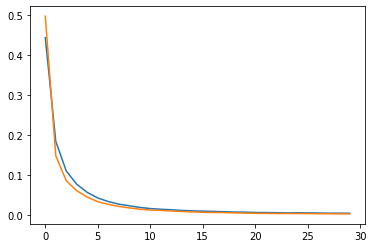

1132
Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.40      0.01         5
               movie.genre       0.10      0.41      0.15       128
       movie.gross_revenue       0.02      0.47      0.05        34
              movie.rating       0.27      0.64      0.38       209
movie.initial_release_date       0.39      0.30      0.34       188
            movie.language       0.32      0.33      0.32       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.12      0.17      0.14        93
      movie.starring.actor       0.45      0.47      0.46       355
            movie.subjects       0.18      0.14      0.16        94
                      none       0.49      0.44      0.46       319
              actor.gender       0.01      0.22      0.01         9
    movie.estimated_budget       0.17      0.32      0.22        79
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.06      0.12       128
       movie.gross_revenue       0.86      0.18      0.29        34
              movie.rating       1.00      0.51      0.68       211
movie.initial_release_date       1.00      0.44      0.61       187
            movie.language       1.00      0.29      0.45       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.05      0.10        92
      movie.starring.actor       1.00      0.40      0.57       354
            movie.subjects       1.00      0.16      0.28        94
                      none       0.98      0.49      0.65       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.23      0.38        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.09      0.17       129
       movie.gross_revenue       0.00      0.00      0.00        34
              movie.rating       1.00      0.63      0.77       210
movie.initial_release_date       1.00      0.60      0.75       188
            movie.language       1.00      0.54      0.70       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.04      0.08        93
      movie.starring.actor       0.99      0.64      0.78       354
            movie.subjects       1.00      0.22      0.35        93
                      none       0.98      0.62      0.76       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.60      0.75        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.26      0.41       129
       movie.gross_revenue       0.00      0.00      0.00        34
              movie.rating       1.00      0.87      0.93       211
movie.initial_release_date       1.00      0.71      0.83       188
            movie.language       1.00      0.80      0.89       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.19      0.32        93
      movie.starring.actor       0.98      0.83      0.90       353
            movie.subjects       1.00      0.39      0.56        94
                      none       0.98      0.78      0.87       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       0.98      0.82      0.90        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.42      0.59       128
       movie.gross_revenue       0.00      0.00      0.00        34
              movie.rating       1.00      0.94      0.97       210
movie.initial_release_date       0.99      0.85      0.92       189
            movie.language       1.00      0.94      0.97       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.48      0.65        93
      movie.starring.actor       0.99      0.95      0.97       353
            movie.subjects       1.00      0.73      0.85        94
                      none       0.98      0.87      0.92       319
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.91      0.95        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.60      0.75       129
       movie.gross_revenue       1.00      0.18      0.30        34
              movie.rating       1.00      0.98      0.99       210
movie.initial_release_date       1.00      0.92      0.96       189
            movie.language       1.00      0.97      0.99       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.75      0.85        93
      movie.starring.actor       0.99      0.96      0.97       354
            movie.subjects       1.00      0.94      0.97        93
                      none       0.98      0.92      0.95       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       0.99      0.94      0.96        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.81      0.90       129
       movie.gross_revenue       1.00      0.41      0.58        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.96      0.98       188
            movie.language       1.00      0.99      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.96      0.85      0.90        92
      movie.starring.actor       0.99      0.99      0.99       353
            movie.subjects       1.00      0.98      0.99        94
                      none       0.99      0.94      0.97       319
              actor.gender       0.00      0.00      0.00         8
    movie.estimated_budget       0.99      0.97      0.98        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.90      0.95       129
       movie.gross_revenue       1.00      0.56      0.72        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.97      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.93      0.96        92
      movie.starring.actor       0.99      0.97      0.98       355
            movie.subjects       1.00      0.99      0.99        94
                      none       0.98      0.95      0.96       316
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.97      0.99        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.95      0.97       128
       movie.gross_revenue       1.00      0.68      0.81        34
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       0.99      0.98      0.99       187
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.95      0.96        93
      movie.starring.actor       0.98      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.95      0.96       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.99      0.99        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      0.76      0.87        34
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       0.99      0.99      0.99       187
            movie.language       1.00      1.00      1.00       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.99      0.98        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.96      0.97       319
              actor.gender       0.00      0.00      0.00         8
    movie.estimated_budget       1.00      0.99      0.99        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.98      0.99       128
       movie.gross_revenue       1.00      0.82      0.90        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.98      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.98      0.98        93
      movie.starring.actor       0.99      0.99      0.99       352
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.97      0.98       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      1.00       128
       movie.gross_revenue       1.00      0.88      0.94        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      1.00      0.98        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.96      0.97       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.94      0.97        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       0.99      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.96      0.97       317
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.94      0.97        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      1.00      0.99        92
      movie.starring.actor       0.99      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.97      0.97       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.98      0.98        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       318
              actor.gender       0.00      0.00      0.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.94      0.97        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       0.99      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      0.22      0.36         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.98      0.98        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      0.99      0.99        93
                      none       0.99      0.98      0.99       319
              actor.gender       1.00      0.44      0.62         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.99      0.98        92
      movie.starring.actor       0.99      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.97      0.99       316
              actor.gender       1.00      0.78      0.88         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.98        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       218
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.98        33
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        92
      movie.starring.actor       0.99      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        91
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.20      0.33         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       352
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.40      0.57         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        92
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.60      0.75         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      0.99      1.00       186
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.98      1.00      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.33      0.50         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      1.00      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      1.00      0.99       186
            movie.language       1.00      1.00      1.00       220
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.33      0.50         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.33      0.50         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.33      0.50         3
movie.production_companies       0.99      0.99      0.99        91
      movie.starring.actor       1.00      1.00      1.00       352
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.98        33
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       186
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        92
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      1.00      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       355
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       352
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       187
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        91
      movie.starring.actor       0.99      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       1.00      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      0.99      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        91
      movie.starring.actor       1.00      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      1.00      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.98      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.97      0.98        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        92
                      none       0.99      1.00      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       352
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.wa

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       126
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      0.99      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        91
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.99      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         8
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.wa

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      0.97      0.98        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      1.00      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       187
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      0.99      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       126
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      0.99      1.00       187
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       216
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      1.00      1.00       187
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.98      0.98        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       0.98      0.98      0.98       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      1.00      1.00       188
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        93
      movie.starring.actor       0.99      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        92
                      none       1.00      0.99      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.98        33
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.98      0.98      0.98       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.98      1.00      0.99       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       352
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       186
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       315
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       0.99      1.00      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.wa

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      0.97      0.99        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       218
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        92
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        92
                      none       1.00      0.99      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       207
movie.initial_release_date       1.00      1.00      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.wa

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.99      1.00       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        93
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       355
            movie.subjects       1.00      1.00      1.00        92
                      none       1.00      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       0.99      1.00      0.99        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       1.00      0.99      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       353
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      0.99      0.99        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       353
            movie.subjects       1.00      1.00      1.00        91
                      none       1.00      0.99      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       209
movie.initial_release_date       1.00      0.99      1.00       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       1.00      0.99      1.00       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.99      0.99       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       187
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      1.00      1.00       352
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       319
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       211
movie.initial_release_date       0.99      0.99      0.99       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        92
      movie.starring.actor       0.99      1.00      1.00       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        76
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       127
       movie.gross_revenue       1.00      1.00      1.00        33
              movie.rating       1.00      1.00      1.00       208
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      0.99      0.99       354
            movie.subjects       1.00      1.00      1.00        94
                      none       0.99      1.00      1.00       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       1.00      1.00      1.00       189
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       0.99      1.00      1.00       352
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      1.00      1.00       318
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        79
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       128
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      0.99      0.99       188
            movie.language       1.00      1.00      1.00       219
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        93
      movie.starring.actor       1.00      1.00      1.00       354
            movie.subjects       1.00      0.99      0.99        94
                      none       0.99      0.99      0.99       317
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        78
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00       129
       movie.gross_revenue       1.00      1.00      1.00        34
              movie.rating       1.00      1.00      1.00       210
movie.initial_release_date       0.99      1.00      1.00       189
            movie.language       1.00      1.00      1.00       220
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        93
      movie.starring.actor       1.00      0.99      1.00       355
            movie.subjects       1.00      1.00      1.00        94
                      none       1.00      0.98      0.99       316
              actor.gender       1.00      1.00      1.00         9
    movie.estimated_budget       1.00      1.00      1.00        77
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

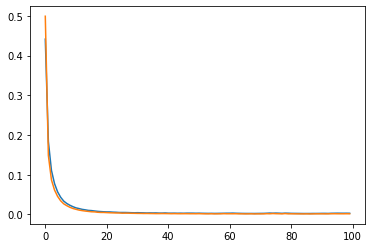

1132
Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.25      0.01         4
               movie.genre       0.07      0.22      0.11        94
       movie.gross_revenue       0.03      0.50      0.05        26
              movie.rating       0.46      0.47      0.47       164
movie.initial_release_date       0.16      0.89      0.27       143
            movie.language       0.33      0.06      0.10       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.08      0.38      0.13        76
      movie.starring.actor       0.56      0.30      0.39       267
            movie.subjects       0.18      0.06      0.09        82
                      none       0.32      0.77      0.45       243
              actor.gender       0.00      0.20      0.01         5
    movie.estimated_budget       0.08      0.80      0.15        61
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.02      0.04        94
       movie.gross_revenue       1.00      0.19      0.32        26
              movie.rating       1.00      0.47      0.64       167
movie.initial_release_date       0.98      0.71      0.83       140
            movie.language       1.00      0.08      0.15       178
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.12      0.21        76
      movie.starring.actor       0.99      0.40      0.57       264
            movie.subjects       1.00      0.05      0.09        84
                      none       0.97      0.59      0.73       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       0.95      0.60      0.73        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       0.00      0.00      0.00        95
       movie.gross_revenue       1.00      0.04      0.07        26
              movie.rating       1.00      0.56      0.72       166
movie.initial_release_date       0.99      0.64      0.78       143
            movie.language       1.00      0.28      0.44       176
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      0.04      0.08        76
      movie.starring.actor       0.99      0.55      0.71       268
            movie.subjects       1.00      0.20      0.33        82
                      none       0.99      0.56      0.72       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.37      0.54        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.10      0.18        93
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      0.79      0.88       166
movie.initial_release_date       1.00      0.64      0.78       141
            movie.language       1.00      0.71      0.83       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.07      0.12        75
      movie.starring.actor       0.99      0.76      0.86       271
            movie.subjects       1.00      0.45      0.62        85
                      none       0.98      0.72      0.83       246
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.41      0.58        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.26      0.41        94
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.92      0.96       166
movie.initial_release_date       0.99      0.71      0.82       143
            movie.language       1.00      0.90      0.95       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.13      0.24        75
      movie.starring.actor       0.99      0.90      0.94       264
            movie.subjects       1.00      0.74      0.85        82
                      none       0.99      0.81      0.89       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.60      0.75        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.40      0.57        96
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      0.96      0.98       167
movie.initial_release_date       1.00      0.75      0.86       139
            movie.language       1.00      0.97      0.99       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.32      0.48        76
      movie.starring.actor       0.98      0.94      0.96       265
            movie.subjects       1.00      0.94      0.97        83
                      none       0.99      0.87      0.93       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.79      0.88        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.65      0.78        96
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.98      0.99       161
movie.initial_release_date       1.00      0.83      0.91       142
            movie.language       1.00      0.98      0.99       179
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.98      0.62      0.76        74
      movie.starring.actor       0.99      0.96      0.97       269
            movie.subjects       1.00      0.98      0.99        81
                      none       0.99      0.90      0.94       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.90      0.95        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.81      0.90        96
       movie.gross_revenue       1.00      0.04      0.07        27
              movie.rating       1.00      0.99      0.99       165
movie.initial_release_date       1.00      0.89      0.94       141
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.98      0.74      0.84        76
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      0.99      0.99        83
                      none       0.98      0.93      0.96       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.95      0.97        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.90      0.95        96
       movie.gross_revenue       1.00      0.11      0.20        27
              movie.rating       1.00      0.99      0.99       162
movie.initial_release_date       1.00      0.93      0.96       139
            movie.language       1.00      0.99      1.00       175
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.99      0.88      0.93        77
      movie.starring.actor       0.99      0.99      0.99       269
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.94      0.97       240
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.96      0.98        94
       movie.gross_revenue       1.00      0.56      0.71        27
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      0.96      0.98       139
            movie.language       1.00      1.00      1.00       178
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.93      0.95        74
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.94      0.97       244
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      0.98      0.99        96
       movie.gross_revenue       1.00      0.71      0.83        24
              movie.rating       1.00      0.99      1.00       166
movie.initial_release_date       1.00      0.96      0.98       139
            movie.language       1.00      1.00      1.00       173
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.99      0.95      0.97        75
      movie.starring.actor       0.99      0.99      0.99       272
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.96      0.98       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      0.74      0.85        27
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.97      0.98        76
      movie.starring.actor       0.99      1.00      0.99       264
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      0.96      0.98       243
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      0.77      0.87        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.98      0.99      0.98       141
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        73
      movie.starring.actor       0.99      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      0.95      0.97       241
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      0.81      0.90        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.98      0.99       140
            movie.language       1.00      1.00      1.00       178
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.97      0.99      0.98        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.99       241
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      0.92      0.96        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.99      0.99       144
            movie.language       1.00      1.00      1.00       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.97      0.98       239
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        57
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      0.99      0.99       269
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.97      0.98       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      0.96      0.98        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       243
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       175
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       0.99      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.98      0.99       247
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       144
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        75
      movie.starring.actor       1.00      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.98       245
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      0.92      0.96        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       0.99      1.00      0.99       265
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.97      0.99       248
              actor.gender       1.00      0.20      0.33         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.20      0.33         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.96      0.97        77
      movie.starring.actor       1.00      0.99      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.98      0.98       247
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.98      0.99       247
              actor.gender       1.00      0.20      0.33         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.60      0.75         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       0.99      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      0.99      0.99       269
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.99       247
              actor.gender       1.00      0.20      0.33         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      0.96      0.98        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       0.99      0.99      0.99       265
            movie.subjects       1.00      1.00      1.00        79
                      none       0.99      0.98      0.99       242
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       0.99      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       247
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      0.99       140
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       139
            movie.language       1.00      1.00      1.00       180
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.98      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       136
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      0.99       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      0.33      0.50         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        98
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      0.99      0.99       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      0.50      0.67         2
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      0.67      0.80         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.98      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       144
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.98      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Val classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        31
       movie.gross_revenue       1.00      0.57      0.73         7
              movie.rating       1.00      0.95      0.97        40
movie.initial_release_date       0.98      0.93      0.95        43
            movie.language       1.00      0.97      0.99        37
               movie.music       0.00      0.00      0.00         0
movie.production_companies       0.93      0.93      0.93        14
      movie.starring.actor       0.98      0.79      0.88        76
            movie.subjects       0.86      0.67      0.75         9
                      none       0.90      0.83      0.87        66
              actor.gender       0.00      0.00      0.00         3
    movie.estimated_budget       1.00      0.86      0.92        14
      pe

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       273
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        78
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       145
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       162
movie.initial_release_date       0.99      1.00      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.97      0.99        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      0.99      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       261
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       259
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      1.00      0.99       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       0.99      0.99      0.99       139
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      0.99      1.00       270
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       158
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.98      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      0.99       269
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      0.99       262
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       0.99      1.00      0.99       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       136
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        72
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      0.84      0.91        31
       movie.gross_revenue       1.00      0.57      0.73         7
              movie.rating       1.00      0.95      0.97        41
movie.initial_release_date       0.97      0.88      0.93        43
            movie.language       1.00      1.00      1.00        37
               movie.music       0.00      0.00      0.00         0
movie.production_companies       0.92      1.00      0.96        12
      movie.starring.actor       0.98      0.80      0.88        76
            movie.subjects       1.00      0.57      0.73         7
                      none       0.84      0.89      0.87        66
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      0.88      0.93        16
      pe

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      0.83      0.91        29
       movie.gross_revenue       1.00      0.67      0.80         6
              movie.rating       1.00      0.95      0.97        41
movie.initial_release_date       0.97      0.86      0.91        43
            movie.language       1.00      1.00      1.00        35
               movie.music       0.00      0.00      0.00         0
movie.production_companies       0.93      0.87      0.90        15
      movie.starring.actor       0.98      0.78      0.87        78
            movie.subjects       0.83      0.62      0.71         8
                      none       0.82      0.88      0.85        66
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      0.88      0.93        16
      pe

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      1.00      0.99       140
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       167
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       164
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       158
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       248
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       134
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       0.99      1.00      0.99       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.98      0.99       237
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       0.99      1.00      0.99       269
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      0.99      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       273
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       236
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        72
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      0.99       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      0.99      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.98       250
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       157
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      0.99       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.99      1.00       162
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        80
                      none       0.99      1.00      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       139
            movie.language       1.00      0.99      0.99       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      0.96      0.98        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      0.99       143
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       0.99      1.00      0.99       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      0.99      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       169
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.99      1.00       162
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      1.00      0.99       240
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        73
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.97      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        89
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.98      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       145
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      1.00      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        89
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       238
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      0.99       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        73
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      0.99       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      0.99       140
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      0.99       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        77
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      1.00       144
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       249
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       236
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.97      0.98       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       0.99      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       138
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.99      0.99       238
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        73
      movie.starring.actor       1.00      1.00      1.00       273
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       234
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       158
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.98      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       0.98      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       0.99      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       0.99      1.00      0.99       266
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       237
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         3
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       136
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      0.99      0.99        84
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      0.75      0.86         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.98      0.99       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.97      1.00      0.99        72
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       273
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      0.99      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       0.99      1.00      0.99       269
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       238
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.98      0.99       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      0.99      0.99       145
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       145
            movie.language       1.00      1.00      1.00       170
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.98      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       250
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        72
      movie.starring.actor       1.00      0.99      1.00       272
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       0.99      1.00      0.99       269
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.98      0.99       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        57
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      0.50      0.67         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        23
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        90
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       260
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.98      0.99       246
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.97      0.99        73
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      0.99      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        89
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       248
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        85
                      none       0.98      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      0.99       142
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       164
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       236
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       0.99      0.99      0.99        77
      movie.starring.actor       1.00      0.99      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.98      0.99       143
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      0.98      0.99        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       237
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       166
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      0.99      0.99       271
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       0.99      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      0.99      1.00       272
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       236
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       238
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       163
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       158
movie.initial_release_date       0.99      1.00      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      0.99      0.99       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       0.98      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       169
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        57
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      1.00      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       145
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      0.99      1.00       164
movie.initial_release_date       1.00      0.99      0.99       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       238
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        72
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       0.99      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      0.99      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.98      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.75      0.86         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      1.00      0.99       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        78
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       0.99      1.00      1.00       273
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       249
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      0.99       142
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       259
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         3
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      0.99      0.99       271
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      0.99      1.00       174
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        97
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       135
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        71
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      0.99      0.99       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       0.99      1.00      0.99       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      0.99      0.99       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       0.99      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       241
              actor.gender       1.00      1.00      1.00         3
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       158
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       274
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        78
                      none       1.00      1.00      1.00       250
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       163
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      0.99      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.98      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.98      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      0.99      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        80
                      none       0.98      0.99      0.98       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        78
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.98      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        23
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       146
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       169
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      1.00       138
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      1.00      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       145
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.99      1.00       163
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      0.98      0.99        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      1.00      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      1.00      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       0.99      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      0.99      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       237
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      0.99      1.00       179
               movie.music       1.00      1.00      1.00         1
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       261
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       140
            movie.language       1.00      1.00      1.00       168
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       170
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       0.99      0.99      0.99       272
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       0.99      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      0.96      0.98        25
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        72
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       145
            movie.language       1.00      1.00      1.00       170
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         3
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        77
                      none       1.00      1.00      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      1.00      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      0.99      0.99       248
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      1.00      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       145
            movie.language       1.00      0.99      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       238
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       145
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        57
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      0.99      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        57
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         1
movie.production_companies       0.99      0.99      0.99        72
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       157
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       250
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.99      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      1.00      0.99       273
            movie.subjects       1.00      1.00      1.00        81
                      none       0.98      1.00      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       168
movie.initial_release_date       0.99      1.00      0.99       139
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        57
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       235
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      0.99      0.99       138
            movie.language       1.00      0.99      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       158
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       260
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.98      0.99       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       261
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       0.99      1.00      0.99       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      0.99      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      0.99      0.99       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      0.99      0.99        82
                      none       1.00      0.98      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       145
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      0.99      0.99       236
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       164
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      0.98      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       144
            movie.language       1.00      1.00      1.00       170
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        80
                      none       0.99      1.00      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       169
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.99      1.00       160
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      1.00      1.00       139
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       157
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        70
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.99      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       0.99      1.00      0.99       144
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      0.96      0.98       137
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       261
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        88
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      0.99       262
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       0.99      1.00      0.99       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       0.99      0.99      0.99       272
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      0.99       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         3
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

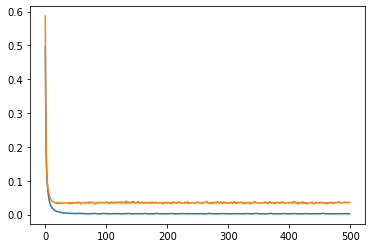

1132


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       0.11      0.13      0.12        93
       movie.gross_revenue       0.03      0.68      0.05        25
              movie.rating       0.33      0.43      0.37       161
movie.initial_release_date       0.37      0.55      0.44       135
            movie.language       0.35      0.53      0.42       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.00      0.00      0.00        75
      movie.starring.actor       0.33      0.47      0.39       268
            movie.subjects       0.10      0.63      0.17        84
                      none       0.39      0.53      0.45       245
              actor.gender       0.00      0.40      0.01         5
    movie.estimated_budget       0.10      0.71      0.17        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       0.00      0.00      0.00        96
       movie.gross_revenue       0.60      0.12      0.19        26
              movie.rating       1.00      0.49      0.66       162
movie.initial_release_date       1.00      0.38      0.55       139
            movie.language       0.97      0.43      0.60       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.00      0.00      0.00        77
      movie.starring.actor       0.99      0.51      0.67       266
            movie.subjects       0.98      0.49      0.66        83
                      none       0.98      0.55      0.70       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.71      0.83        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.02      0.04        96
       movie.gross_revenue       0.00      0.00      0.00        25
              movie.rating       1.00      0.54      0.70       165
movie.initial_release_date       1.00      0.45      0.62       140
            movie.language       1.00      0.52      0.69       178
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.00      0.00      0.00        75
      movie.starring.actor       0.99      0.57      0.72       269
            movie.subjects       1.00      0.29      0.45        85
                      none       0.98      0.55      0.70       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.60      0.75        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.17      0.29        95
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.79      0.88       164
movie.initial_release_date       1.00      0.63      0.77       143
            movie.language       1.00      0.77      0.87       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.01      0.03        74
      movie.starring.actor       1.00      0.74      0.85       272
            movie.subjects       1.00      0.37      0.54        84
                      none       0.98      0.71      0.82       239
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.60      0.75        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      0.38      0.55        95
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.92      0.96       162
movie.initial_release_date       1.00      0.70      0.83       142
            movie.language       1.00      0.91      0.96       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.92      0.15      0.26        73
      movie.starring.actor       0.99      0.88      0.93       269
            movie.subjects       1.00      0.63      0.77        81
                      none       0.98      0.81      0.89       249
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.75      0.86        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      0.64      0.78        96
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.98      0.99       162
movie.initial_release_date       1.00      0.80      0.89       142
            movie.language       1.00      0.95      0.98       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.45      0.61        76
      movie.starring.actor       0.99      0.92      0.95       268
            movie.subjects       1.00      0.83      0.91        82
                      none       0.98      0.89      0.93       241
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.85      0.92        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.76      0.87        97
       movie.gross_revenue       0.00      0.00      0.00        25
              movie.rating       1.00      0.99      0.99       163
movie.initial_release_date       1.00      0.88      0.94       142
            movie.language       1.00      0.99      0.99       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.76      0.85        74
      movie.starring.actor       0.99      0.96      0.98       265
            movie.subjects       1.00      0.88      0.93        80
                      none       0.99      0.92      0.96       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.86      0.93        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.92      0.96        97
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      0.99      1.00       162
movie.initial_release_date       1.00      0.92      0.96       142
            movie.language       1.00      0.99      0.99       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.87      0.92        75
      movie.starring.actor       0.99      0.97      0.98       268
            movie.subjects       1.00      0.98      0.99        82
                      none       0.99      0.93      0.96       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.97      0.98        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.95      0.97        95
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.97      0.99       140
            movie.language       1.00      0.99      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.92      0.95        75
      movie.starring.actor       0.99      0.98      0.98       267
            movie.subjects       1.00      0.99      0.99        84
                      none       1.00      0.95      0.97       243
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.98      0.99        95
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.99      0.99       158
movie.initial_release_date       1.00      0.97      0.99       142
            movie.language       1.00      1.00      1.00       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.96      0.97        77
      movie.starring.actor       0.99      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.95      0.97       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.97      0.98        98
       movie.gross_revenue       1.00      0.23      0.38        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.97      0.98       144
            movie.language       1.00      1.00      1.00       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.95      0.97        75
      movie.starring.actor       0.99      0.99      0.99       270
            movie.subjects       1.00      1.00      1.00        84
                      none       0.98      0.96      0.97       246
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.98      0.99        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        98
       movie.gross_revenue       1.00      0.62      0.76        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.98      0.99       140
            movie.language       1.00      1.00      1.00       180
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.99      0.98        73
      movie.starring.actor       1.00      0.99      0.99       271
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.97      0.98       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        97
       movie.gross_revenue       1.00      0.73      0.84        26
              movie.rating       1.00      0.99      1.00       162
movie.initial_release_date       1.00      0.99      0.99       144
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        74
      movie.starring.actor       1.00      0.99      0.99       262
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.97      0.98       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        98
       movie.gross_revenue       1.00      0.81      0.89        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      0.99       140
            movie.language       1.00      1.00      1.00       178
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       0.99      1.00      0.99       263
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.96      0.98       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      0.85      0.92        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        76
      movie.starring.actor       0.99      1.00      0.99       268
            movie.subjects       1.00      1.00      1.00        78
                      none       0.99      0.98      0.98       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      0.96      0.98        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       246
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.99      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       173
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.98      0.98       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       136
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        80
                      none       0.99      0.98      0.98       247
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.97      0.98       243
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.20      0.33         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       0.99      1.00      0.99       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.98      0.99       242
              actor.gender       1.00      0.20      0.33         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.40      0.57         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        73
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       243
              actor.gender       1.00      0.40      0.57         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      0.99      0.99       138
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.98      0.99       244
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.40      0.57         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       178
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.99      0.99       242
              actor.gender       1.00      0.60      0.75         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      1.00      0.99       137
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      0.99      0.99       262
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        78
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      1.00       241
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.99      0.99        74
      movie.starring.actor       0.99      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.98      0.99       242
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      0.99      0.99       142
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      1.00      1.00       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      1.00      1.00       143
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       0.99      1.00      0.99       269
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      0.33      0.50         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.98      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      1.00      0.99       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       261
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.98      0.99       243
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      0.99      1.00       166
movie.initial_release_date       1.00      0.99      1.00       136
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        23
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       0.99      0.99      0.99       138
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        73
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Val classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         0
               movie.genre       1.00      0.87      0.93        30
       movie.gross_revenue       1.00      0.57      0.73         7
              movie.rating       1.00      0.95      0.97        41
movie.initial_release_date       0.97      0.83      0.89        41
            movie.language       1.00      1.00      1.00        38
               movie.music       0.00      0.00      0.00         0
movie.production_companies       0.93      0.93      0.93        15
      movie.starring.actor       0.98      0.78      0.87        78
            movie.subjects       0.86      0.67      0.75         9
                      none       0.84      0.86      0.85        65
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      0.87      0.93        15
      pe

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       136
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.98      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      0.99      1.00       265
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       0.99      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.97      0.99        75
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        79
                      none       0.99      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      0.67      0.80         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      0.98      0.99        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      0.99      1.00       166
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      0.99      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       144
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       138
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         3
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       171
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       273
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      0.99       137
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       0.99      0.99      0.99       145
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       0.99      1.00      1.00       274
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      0.99      0.99       269
            movie.subjects       1.00      1.00      1.00        85
                      none       0.99      1.00      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      1.00      0.99       266
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        72
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        98
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        77
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       235
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.99      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       0.99      0.99      0.99        74
      movie.starring.actor       1.00      1.00      1.00       270
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      0.99      1.00       267
            movie.subjects       1.00      1.00      1.00        79
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      0.99      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.99      0.99       248
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       141
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       139
            movie.language       1.00      1.00      1.00       172
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       245
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         3
               movie.genre       1.00      0.99      0.99        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       138
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       158
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        73
      movie.starring.actor       1.00      1.00      1.00       271
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       261
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         2
movie.production_companies       0.99      1.00      0.99        72
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      1.00      0.99       264
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      1.00      1.00       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      0.99      0.99       137
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       240
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       168
movie.initial_release_date       1.00      1.00      1.00       141
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       243
              actor.gender       1.00      1.00      1.00         3
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      1.00      1.00       141
            movie.language       1.00      1.00      1.00       179
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      1.00      1.00       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      0.99       144
            movie.language       1.00      1.00      1.00       173
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      1.00      1.00       245
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      1.00      1.00       145
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         2
movie.production_companies       0.99      1.00      0.99        77
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      1.00      1.00       242
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        58
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       143
            movie.language       1.00      1.00      1.00       181
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       262
            movie.subjects       1.00      1.00      1.00        81
                      none       0.99      0.98      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       246
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       140
            movie.language       1.00      1.00      1.00       180
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.97      0.99        77
      movie.starring.actor       1.00      0.99      1.00       268
            movie.subjects       1.00      1.00      1.00        80
                      none       0.99      1.00      0.99       244
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       177
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       264
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.99      0.99       239
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      1.00      1.00       137
            movie.language       1.00      1.00      1.00       178
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      0.99      0.99       269
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.99      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      1.00      1.00        24
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       142
            movie.language       1.00      1.00      1.00       176
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       265
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      1.00      1.00       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      0.99      0.99        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       164
movie.initial_release_date       1.00      1.00      1.00       139
            movie.language       1.00      1.00      1.00       175
               movie.music       1.00      1.00      1.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       241
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

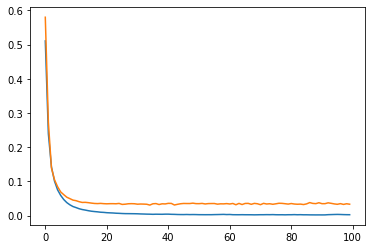

1132


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.20      0.01         5
               movie.genre       0.10      0.38      0.16        93
       movie.gross_revenue       0.02      0.37      0.04        27
              movie.rating       0.33      0.33      0.33       160
movie.initial_release_date       0.35      0.63      0.45       142
            movie.language       0.24      0.37      0.29       176
               movie.music       0.00      0.33      0.01         3
movie.production_companies       0.13      0.16      0.14        77
      movie.starring.actor       0.33      0.63      0.43       262
            movie.subjects       0.26      0.35      0.30        82
                      none       0.36      0.60      0.45       241
              actor.gender       0.00      0.60      0.01         5
    movie.estimated_budget       0.41      0.11      0.18        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being s

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.27      0.42        94
       movie.gross_revenue       1.00      0.04      0.07        26
              movie.rating       1.00      0.49      0.66       160
movie.initial_release_date       0.99      0.56      0.72       139
            movie.language       1.00      0.20      0.33       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.03      0.05        78
      movie.starring.actor       0.94      0.61      0.74       267
            movie.subjects       1.00      0.12      0.21        84
                      none       0.99      0.52      0.69       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.23      0.38        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.12      0.21        94
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      0.59      0.74       164
movie.initial_release_date       1.00      0.56      0.72       138
            movie.language       1.00      0.28      0.44       178
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.04      0.08        77
      movie.starring.actor       0.98      0.65      0.79       269
            movie.subjects       1.00      0.07      0.14        80
                      none       0.99      0.57      0.72       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.26      0.42        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.23      0.37        93
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      0.78      0.88       161
movie.initial_release_date       1.00      0.68      0.81       139
            movie.language       1.00      0.64      0.78       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.08      0.15        75
      movie.starring.actor       0.99      0.79      0.87       267
            movie.subjects       1.00      0.17      0.29        83
                      none       0.99      0.63      0.77       243
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      0.52      0.68        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.39      0.56        96
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.94      0.97       166
movie.initial_release_date       1.00      0.74      0.85       140
            movie.language       1.00      0.88      0.94       180
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.94      0.19      0.32        77
      movie.starring.actor       0.98      0.87      0.92       267
            movie.subjects       1.00      0.41      0.58        80
                      none       0.99      0.81      0.89       243
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.77      0.87        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.52      0.68        93
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      0.99      0.99       165
movie.initial_release_date       1.00      0.83      0.91       139
            movie.language       1.00      0.94      0.97       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.95      0.47      0.63        76
      movie.starring.actor       0.98      0.92      0.95       265
            movie.subjects       1.00      0.70      0.83        84
                      none       0.99      0.86      0.92       243
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.89      0.94        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      0.66      0.79        96
       movie.gross_revenue       0.00      0.00      0.00        26
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       1.00      0.88      0.94       144
            movie.language       1.00      0.98      0.99       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.98      0.69      0.81        74
      movie.starring.actor       0.99      0.96      0.98       269
            movie.subjects       1.00      0.91      0.96        82
                      none       0.98      0.93      0.95       243
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.94      0.97        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.78      0.88        95
       movie.gross_revenue       0.00      0.00      0.00        27
              movie.rating       1.00      0.99      1.00       163
movie.initial_release_date       1.00      0.93      0.96       144
            movie.language       1.00      0.99      1.00       173
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      0.86      0.92        77
      movie.starring.actor       0.99      0.98      0.99       268
            movie.subjects       1.00      0.96      0.98        82
                      none       0.99      0.93      0.96       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.97      0.98        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.91      0.95        96
       movie.gross_revenue       1.00      0.33      0.50        27
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       1.00      0.94      0.97       143
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.92      0.95        76
      movie.starring.actor       0.99      0.98      0.99       262
            movie.subjects       1.00      0.98      0.99        81
                      none       0.98      0.94      0.96       244
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         4
               movie.genre       1.00      0.96      0.98        97
       movie.gross_revenue       1.00      0.54      0.70        26
              movie.rating       1.00      1.00      1.00       162
movie.initial_release_date       1.00      0.96      0.98       144
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.97      0.97        78
      movie.starring.actor       0.99      0.98      0.98       262
            movie.subjects       1.00      0.99      0.99        82
                      none       0.98      0.96      0.97       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        96
       movie.gross_revenue       1.00      0.72      0.84        25
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       1.00      0.97      0.99       142
            movie.language       1.00      1.00      1.00       172
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.99      0.96      0.97        77
      movie.starring.actor       0.99      0.99      0.99       268
            movie.subjects       1.00      1.00      1.00        80
                      none       0.99      0.95      0.97       249
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.98      0.99        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.98      0.99        91
       movie.gross_revenue       1.00      0.89      0.94        27
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       1.00      0.98      0.99       143
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      0.99      0.99        74
      movie.starring.actor       1.00      0.99      0.99       267
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.97      0.98       247
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      0.92      0.96        26
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         2
movie.production_companies       0.97      1.00      0.99        71
      movie.starring.actor       0.99      1.00      0.99       271
            movie.subjects       1.00      1.00      1.00        82
                      none       0.98      0.97      0.98       247
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      0.92      0.96        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       141
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.97      0.99        77
      movie.starring.actor       0.99      1.00      0.99       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.98      0.99       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      0.99      0.99        94
       movie.gross_revenue       1.00      0.96      0.98        27
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       178
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.97      0.97      0.97        76
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.98      0.99       238
              actor.gender       0.00      0.00      0.00         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        91
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       1.00      0.99      0.99       142
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        76
      movie.starring.actor       0.99      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        79
                      none       0.99      0.97      0.98       245
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.20      0.33         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       1.00      0.99      1.00       143
            movie.language       1.00      1.00      1.00       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.97      0.99        75
      movie.starring.actor       1.00      0.99      1.00       270
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.98      0.99       241
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      0.98      0.99        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.25      0.40         4
               movie.genre       1.00      0.99      0.99        98
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       140
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       0.00      0.00      0.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       144
            movie.language       1.00      1.00      1.00       178
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       0.99      1.00      0.99       267
            movie.subjects       1.00      1.00      1.00        78
                      none       1.00      0.98      0.99       243
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      0.80      0.89         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       175
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       0.99      0.98      0.99       242
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       166
movie.initial_release_date       1.00      0.99      1.00       139
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      0.98      0.99       266
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.98      0.99       241
              actor.gender       0.00      0.00      0.00         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       0.99      0.99      0.99       140
            movie.language       1.00      1.00      1.00       175
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      0.97      0.99        74
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        82
                      none       1.00      0.98      0.99       244
              actor.gender       1.00      0.20      0.33         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        96
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       159
movie.initial_release_date       0.99      0.99      0.99       141
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        75
      movie.starring.actor       1.00      1.00      1.00       272
            movie.subjects       1.00      1.00      1.00        80
                      none       1.00      0.99      0.99       242
              actor.gender       1.00      0.40      0.57         5
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       167
movie.initial_release_date       1.00      0.99      0.99       143
            movie.language       1.00      1.00      1.00       176
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      0.99      0.99        76
      movie.starring.actor       1.00      0.99      1.00       266
            movie.subjects       1.00      1.00      1.00        83
                      none       1.00      0.98      0.99       242
              actor.gender       1.00      0.20      0.33         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         4
               movie.genre       1.00      1.00      1.00        94
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      0.99      1.00       165
movie.initial_release_date       1.00      0.99      1.00       144
            movie.language       1.00      1.00      1.00       179
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      1.00      1.00        75
      movie.starring.actor       1.00      1.00      1.00       267
            movie.subjects       1.00      1.00      1.00        81
                      none       1.00      0.97      0.98       247
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        92
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       161
movie.initial_release_date       0.99      0.99      0.99       143
            movie.language       1.00      1.00      1.00       172
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      0.99      0.99        75
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.98      0.99       243
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        62
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        93
       movie.gross_revenue       1.00      1.00      1.00        25
              movie.rating       1.00      1.00      1.00       165
movie.initial_release_date       1.00      0.99      0.99       140
            movie.language       1.00      1.00      1.00       172
               movie.music       0.00      0.00      0.00         3
movie.production_companies       0.99      1.00      0.99        78
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        84
                      none       1.00      0.99      0.99       244
              actor.gender       1.00      0.80      0.89         5
    movie.estimated_budget       1.00      1.00      1.00        63
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       163
movie.initial_release_date       0.99      1.00      1.00       142
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        76
      movie.starring.actor       1.00      1.00      1.00       263
            movie.subjects       1.00      1.00      1.00        85
                      none       1.00      0.97      0.98       248
              actor.gender       1.00      1.00      1.00         4
    movie.estimated_budget       1.00      1.00      1.00        59
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        95
       movie.gross_revenue       1.00      1.00      1.00        27
              movie.rating       1.00      1.00      1.00       169
movie.initial_release_date       1.00      0.99      1.00       137
            movie.language       1.00      1.00      1.00       177
               movie.music       0.00      0.00      0.00         2
movie.production_companies       1.00      1.00      1.00        77
      movie.starring.actor       1.00      1.00      1.00       268
            movie.subjects       1.00      1.00      1.00        82
                      none       0.99      0.97      0.98       241
              actor.gender       1.00      0.75      0.86         4
    movie.estimated_budget       1.00      1.00      1.00        60
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Train classification report after epoch:
                            precision    recall  f1-score   support

                 gr.amount       1.00      1.00      1.00         5
               movie.genre       1.00      1.00      1.00        97
       movie.gross_revenue       1.00      1.00      1.00        26
              movie.rating       1.00      1.00      1.00       160
movie.initial_release_date       1.00      0.99      1.00       142
            movie.language       1.00      1.00      1.00       174
               movie.music       0.00      0.00      0.00         3
movie.production_companies       1.00      1.00      1.00        74
      movie.starring.actor       1.00      1.00      1.00       269
            movie.subjects       1.00      1.00      1.00        84
                      none       0.99      0.99      0.99       247
              actor.gender       1.00      1.00      1.00         5
    movie.estimated_budget       1.00      1.00      1.00        61
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

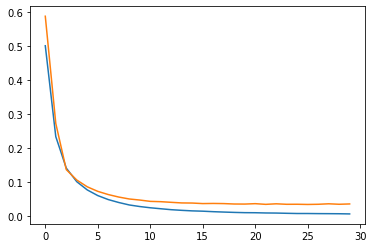

In [189]:
model_number = '4_full'
args = Namespace(
    # Data and path information
    movie_csv='/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv',
    save_dir='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/',
    model_number=model_number,
    dataset_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/dataset.pkl'.format(model_number),
    vectroizer_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/vectroizer.pkl'.format(model_number),
    label_indexer_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/label_indexer.pkl'.format(model_number),
    model_state_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/model.pth'.format(model_number),
    train_state_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/train_state.pkl'.format(model_number),
    submission_path = '/content/drive/MyDrive/NLP243/assignments/1/model/20221007/{}/submission.csv'.format(model_number),
    # Training hyperparameters
    hidden_size=100,
    batch_size=64,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=30
    # Runtime options omitted for space
)

if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

In [190]:
classifier_state_dict = torch.load(args.model_state_file)
dataset = pkl.load(open(args.dataset_file, "rb"))
vectorizer = dataset.get_vectorizer()
label_indexer = dataset.get_label_indexer()
labels = [label_indexer.idx2label[_idx] for _idx in range(len(label_indexer))]

# model
classifier = MLPMultiLabelClassifier(input_size=len(vectorizer.text_vocab), hidden_size=args.hidden_size, output_size=len(label_indexer))
classifier.load_state_dict(classifier_state_dict)
classifier = classifier.to(args.device)
classifier.eval()


MLPMultiLabelClassifier(
  (fc1): Linear(in_features=1101, out_features=100, bias=True)
  (batch_norm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [186]:
from numpy.core.fromnumeric import reshape
from pandas._libs.tslibs import vectorized
def predict_labels(text, classifier, vectorizer, label_indexer,
                   decision_threshold=0.5, tfidf=False):
    """Predict the rating of a review

    Args:
        text (str): the text of the movie
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which
            separates the rating classes
    """

    processed_text = preprocess_text(text)
    if tfidf:
      vectorized_text = torch.FloatTensor(vectorizer.transform([processed_text]).todense()).squeeze(0)
      y_pred = classifier(vectorized_text)
    else:
      vectorized_text = torch.tensor(vectorizer.vectorize(processed_text))
      reshaped_vectorized_text = torch.reshape(vectorized_text, (1, vectorized_text.shape[0]))
      y_pred = classifier(torch.cat((reshaped_vectorized_text, reshaped_vectorized_text), dim=0).squeeze())[0]
    y_pred_normalized = F.sigmoid(y_pred)
    y_pred_labels = y_pred_normalized >= decision_threshold
    labels = [label_indexer.idx2label[_idx] for _idx, value in enumerate(y_pred_labels.tolist()) if value]
    return labels

test_movies_csv = '/content/drive/MyDrive/NLP243/assignments/1/hw1_test-2.csv'
test_movies_df = pd.read_csv(test_movies_csv)
test_movies_df.columns = ["id", "text"]
all_text_labels = []
all_text_ids = []
for _idx, _text in enumerate(test_movies_df.text, 0):
    labels = predict_labels(text=_text, classifier=classifier, vectorizer=vectorizer, label_indexer=label_indexer, decision_threshold=0.5)
    labels = ["" if _label == 'none' else _label for _label in labels]
    formatted_labels = " ".join(labels).strip()
    all_text_ids.append(_idx)
    all_text_labels.append(formatted_labels)
    print(_idx)
    print("text: {}".format(_text))
    print("labels: {}".format(formatted_labels))

submission_columns = ["ID", "CORE RELATIONS"]
submission_df = pd.DataFrame(columns=submission_columns, data={"ID": all_text_ids, "CORE RELATIONS": all_text_labels})
print(submission_df)
submission_df.to_csv(args.submission_path, index=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0
text: star of thor
labels: movie.starring.actor
1
text: who is in the movie the campaign
labels: movie.starring.actor
2
text: list the cast of the movie the campaign
labels: movie.starring.actor
3
text: who was in twilight
labels: movie.starring.actor
4
text: who is in vulguria
labels: 
5
text: actor from lost
labels: movie.starring.actor
6
text: who played in the movie rocky
labels: movie.starring.actor
7
text: who played in the movie captain america
labels: movie.starring.actor
8
text: cast and crew for in july
labels: movie.starring.actor
9
text: who is in movie in july
labels: 
10
text: who's in star wars episode four
labels: movie.starring.actor
11
text: who was in apollo thirteen
labels: movie.starring.actor
12
text: who was apollo thirteen 's cast
labels: movie.starring.actor
13
text: search for information about the cast and crew of appolo thirteen
labels: movie.starring.actor
14
text: i would like to know more about the cast and crew of the movie apollo thirteen
labels: movi

In [197]:
df1 = pd.read_csv('/content/drive/MyDrive/NLP243/assignments/1/model/20221007/2_full/submission.csv')
# df2 = pd.read_csv('/content/drive/MyDrive/NLP243/assignments/1/submission_3.csv')
df2 = pd.read_csv('/content/drive/MyDrive/NLP243/assignments/1/model/20221007/4_full/submission.csv')
df3 = pd.read_csv('/content/drive/MyDrive/NLP243/assignments/1/submission_2.csv')

# # test_movies_df.reset_index(inplace=True)
# # df2.reset_index(inplace=True)

# # test_movies_df.drop(columns=['level_0', 'index'], axis=1, inplace=True)
# # print(test_movies_df)
# # print(df2)
# df3 = pd.merge(df1, df2, how='inner', left_on='ID', right_on='ID')
# # df3.drop(columns=['id', 'text'], axis=1, inplace=True)
# # print(df3)
# df3['CORE RELATIONS'] = ""
# df3_list = list(row.to_dict() for _, row in df3.iterrows())
# df4_list = []
# count = 0
# for _x in df3_list:
#   if _x['CORE RELATIONS_x'] != _x['CORE RELATIONS_x']:
#     _x['CORE RELATIONS'] = _x['CORE RELATIONS_y']
#     count += 1
#   else:
#     _x['CORE RELATIONS'] = _x['CORE RELATIONS_y']
#   df4_list.append(_x)
# df4 = pd.DataFrame(df4_list)
# print(df4)
# print(count)
# df4.drop(columns=['CORE RELATIONS_x', 'CORE RELATIONS_y'], axis=1, inplace=True)
# df4.tail()
# df4.to_csv('/content/drive/MyDrive/NLP243/assignments/1/submission_4.csv', index=False)
# # df3.to_csv('/content/drive/MyDrive/NLP243/assignments/1/submission_2_with_text.csv')

In [196]:
mismatch_id = []
mismatch_text = []
df_text = list(test_movies_df['text'])
df1_idx = list(df1['ID'])
df1_relations = list(df1['CORE RELATIONS'])
df2_idx = list(df2['ID'])
df2_relations = list(df2['CORE RELATIONS'])
df3_relations = list(df3['CORE RELATIONS'])

_idx = 0
for _x, _y, _z, _text in zip(df1_relations, df2_relations, df3_relations, df_text):
  if _x != _y:
    if pd.isnull(pd.Series([_x])).to_list()[0] and pd.isnull(pd.Series([_y])).to_list()[0]:
      pass
    elif pd.isnull(pd.Series([_x])).to_list()[0]:
      mismatch_text.append((_x, _y))
      mismatch_id.append(df1_idx[_idx])
      print("{}, {}, {}, {}".format(df1_idx[_idx], _text, _x, _y)) 
    elif pd.isnull(pd.Series([_y])).to_list()[0]:
      mismatch_text.append((_x, _y))
      mismatch_id.append(df1_idx[_idx])
      print("{}, {}, {}, {}".format(df1_idx[_idx], _text, _x, _y)) 
    elif set(_x.split()).intersection(set(_y.split())) == set(_x.split()).union(set(_y.split())):
      mismatch_text.append((_x, _y))
      mismatch_id.append(df1_idx[_idx])
      print("{}, {}, {}, {}".format(df1_idx[_idx], _text, _x, _y)) 
  _idx += 1

5, actor from lost, nan, movie.starring.actor
19, dirty dancing actors, nan, movie.starring.actor
53, what was spent on my big fat greek wedding, movie.estimated_budget, nan
59, spain has how many movies, movie.country, nan
71, origin of king lear, nan, movie.country
74, when did will ferrell begin acting, movie.initial_release_date, nan
109, what day is fun size coming out, movie.initial_release_date, nan
122, dirctor of movie avengers, nan, movie.directed_by
137, who is director of the words, nan, movie.directed_by
184, find out what language the father of my children is in, movie.language, nan
206, will smith acting carrer, nan, movie.starring.character
272, look for dirty dancing movie with jennifer grey, movie.starring.actor, nan
356, steven spielberg movie, nan, movie.directed_by
384, what did brad pitt porduce, nan, movie.starring.actor
415, display 7 arts movies, movie.production_companies, nan
424, want to see robert wise movies, movie.directed_by, nan
491, search by director,

In [202]:
df_2_full_4_full = df2
_idx = 0
df_2_full_4_full_relations = []
_idx = 0

for _x, _y, _text in zip(df1_relations, df2_relations, df_text):
  if _x != _y:
    if pd.isnull(pd.Series([_x])).to_list()[0] and pd.isnull(pd.Series([_y])).to_list()[0]:
      df_2_full_4_full_relations.append(_y)
    elif pd.isnull(pd.Series([_x])).to_list()[0]:
      df_2_full_4_full_relations.append(_y)
    elif pd.isnull(pd.Series([_y])).to_list()[0]:
      df_2_full_4_full_relations.append(_x)
    elif set(_x.split()).intersection(set(_y.split())) != set(_x.split()).union(set(_y.split())):
      df_2_full_4_full_relations.append(" ".join(list(set(_x.split()).union(set(_y.split())))))
      print("{}, {}, {}, {}".format(df1_idx[_idx], _text, _x, _y)) 
  else:
    df_2_full_4_full_relations.append(_x)
  _idx +=1

df_2_full_4_full["CORE RELATIONS"] = df_2_full_4_full_relations
df_2_full_4_full.to_csv('/content/drive/MyDrive/NLP243/assignments/1/model/20221007/2_full_4_full/submission.csv', index=False)

43, how much money did they spend to make avatar, movie.estimated_budget, movie.gross_revenue movie.estimated_budget
80, what year did the italian movie roman holiday come out, movie.initial_release_date, movie.initial_release_date movie.country
188, ron howard name some of the movies he produce, movie.produced_by, movie.produced_by movie.directed_by
250, show me something italian - made, movie.language, movie.language movie.country
495, find newly released comedies from england, movie.genre, movie.country
532, are there any recent movies that are polish speaking, movie.initial_release_date movie.language, movie.language
565, what company made et, movie.production_companies movie.directed_by, movie.production_companies
611, what is the new will ferrell movie about, movie.initial_release_date, movie.initial_release_date movie.starring.actor
627, what is the name of the actress who played mother in tarkovsky 's mirror, movie.starring.actor, movie.starring.actor movie.starring.character
6

In [ ]:
class MultiClassTrainer(object):
    
    def __init__(self, model, optimizer, loss_fn, device="cpu", log_every_n=None):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = loss_fn

        self.log_every_n = log_every_n if log_every_n else 0


    def _print_summary(self):
        print(self.model)
        print(self.optimizer)
        print(self.loss_fn)

    def evaluate(self, loader, labels):
        """
        Evaluate the model on a validation set
        """

        self.model.eval() # Run model in eval mode (disables dropout layer)

        batch_wise_true_labels = []
        batch_wise_predictions = []

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        with torch.no_grad(): # Disable gradient computation - required only during training
            for i, batch_dict in tqdm(enumerate(loader)):
                # batch[0] shape: (batch_size, input_size)

                y_pred = self.model(batch_dict['x_data'].float().to(self.device))
                # logits shape: (batch_size, num_classes)
        
                # print("y_pred: {}".format(y_pred))

                # step 3. compute the loss
                loss = self.loss_func(y_pred, batch_dict['y_target'].squeeze().float().to(self.device))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (batch_index + 1)
                loss_history.append(loss_batch)
                running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
                running_loss_history.append(running_loss)

                # logits : [batch_size, num_classes] and each of the values in logits can be anything (-infinity, +infity)
                # Converts the raw outputs into probabilities for each class using softmax
                y_pred_normalized = F.sigmoid(logits)
                y_pred_labels = y_pred_normalized >= 0.5
                # probs shape: (batch_size, num_classes)

                batch_wise_true_labels.append(batch_dict['y_target'].tolist())
                batch_wise_predictions.append(y_pred_labels.tolist())
        
        # flatten the list of predictions using itertools
        all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
        all_predictions = list(chain.from_iterable(batch_wise_predictions))

        # Now we can generate a classification report
        print("Classification report after epoch:")
        print(classification_report(all_true_labels, all_predictions, target_names=labels))

        return loss_history, running_loss_history

    def get_model_dict(self):
        return self.model.state_dict()

In [ ]:
for _x in train_state['train_loss']:
  print(_x)

0.19637909792444277
0.10271475106846645


In [ ]:
for _x in train_state['train_p']:
  print(_x)

0.03517316017316016
0.39475108225108274


In [ ]:
for _x in train_state['train_r']:
  print(_x)

0.03490259740259739
0.3870400432900438


In [ ]:
for _x in train_state['train_f1']:
  print(_x)

0.034992784992784985
0.38928571428571446


In [ ]:
for _x in train_state['val_loss']:
  print(_x)

0.12506512976634554
0.09035531236302279


In [ ]:
for _x in train_state['val_p']:
  print(_x)

0.1861471861471862
0.5064935064935064


In [ ]:
for _x in train_state['val_r']:
  print(_x)

0.185064935064935
0.48917748917748927


In [ ]:
for _x in train_state['val_f1']:
  print(_x)

0.1854256854256854
0.494949494949495


In [ ]:
def compute_metrics(y_pred, y_target):

  # print("batch size: {}".format(args.batch_size))

  p = 0
  r = 0
  f1 = 0
  print("y_target")
  print(y_target)
  print()
  print("y_target_refined")
  print(y_target >= 0.5)
  print()
  print("y_pred")
  print(y_pred)
  print()
  print("y_pred_refined")
  print(y_pred >= 0.5)
  print()

  p = precision_score(y_target.to('cpu') >= 0.5, y_pred.to('cpu') >=0.5, average="samples")
  r = recall_score(y_target.to('cpu') >= 0.5, y_pred.to('cpu') >=0.5, average="samples")
  f1 = f1_score(y_target.to('cpu') >= 0.5, y_pred.to('cpu') >=0.5, average="samples")

  print("precision: {}".format(p))
  print("recall: {}".format(r))
  print("f1: {}".format(f1))

  # if args.batch_size <= 1:
  #   f1_idx = f1_score(y_target, y_pred >=0.5, average="samples")
  #   p_idx = precision_score(y_target, y_pred >=0.5, average="samples")
  #   r_idx = recall_score(y_target, y_pred >=0.5, average="samples")
  #   # acc = sklearn.accuracy(y_target, y_pred >=0.5, average="samples")

  #   p += p_idx
  #   r += r_idx
  #   f1 += f1_idx
  
  # else:
  #   for _idx in range(args.batch_size):
  #     f1_idx = f1_score(y_target[_idx], y_pred[_idx] >=0.5, average="samples")
  #     p_idx = precision_score(y_target[_idx], y_pred[_idx] >=0.5, average="samples")
  #     r_idx = recall_score(y_target[_idx], y_pred[_idx] >=0.5, average="samples")
  #     # acc = sklearn.accuracy(y_target, y_pred >=0.5, average="samples")

  #     p += p_idx
  #     r += r_idx
  #     f1 += f1_idx

  # p = p/args.batch_size
  # r = r/args.batch_size
  # f1 = f1/args.batch_size
  
  return p, r, f1